## Insertar Dependencias y Librerías


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,  make_scorer, classification_report,
    precision_recall_curve, roc_curve, precision_score, recall_score, f1_score,
    confusion_matrix, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

base_abs = Path(r"/Users/yaelmarquez/Documents/VS_CODE/MNAV  - Maestría en Inteligencia Artificial Aplicada/Operaciones de aprendizaje automático/MLOps/proyect_team42/data/ml_data")

df_train = pd.read_csv(base_abs / "insurance_train.csv")
df_test  = pd.read_csv(base_abs / "insurance_test.csv")

TARGET_COL = "MoHoPol"
assert TARGET_COL in df_train.columns and TARGET_COL in df_test.columns, "MoHoPol no encontrado."

# Tipos seguros
for df in (df_train, df_test):
    if df[TARGET_COL].dtype != "int64" and df[TARGET_COL].dtype != "int32":
        df[TARGET_COL] = df[TARGET_COL].astype(int)

print("Train:", df_train.shape, "| Positivos(%):", round(100*df_train[TARGET_COL].mean(), 2))
print("Test :", df_test.shape,  "| Positivos(%):", round(100*df_test[TARGET_COL].mean(), 2))

Train: (4656, 86) | Positivos(%): 5.97
Test : (1165, 86) | Positivos(%): 6.01


## Selección de variables relevantes y cross-features

In [ ]:

# Lista prioritaria
PRIORITY_FEATURES = [
    "ContrCarPol", "NumCarPol",
    "ContrFirePol",
    "DemAvgIncome", "DemMidInc", "DemLoLeEdu", "DemHiLeEdu", "DemLowestInc",
    "ContrPrivIns",
    "CMainType",
]

# Mapeo desde nombres COIL 
COIL_TO_CLEAN = {
    "PPERSAUT": "ContrCarPol",
    "APERSAUT": "NumCarPol",
    "PBRAND":   "ContrFirePol",
    "ABRAND":   "NumFirePol",
    "PWAPART":  "ContrPrivIns",
    "AWAPART":  "NumPrivIns",
    "MKOOPKLA": "CMainType",
}

def resolve_name(name: str, cols) -> str | None:
    """Devuelve el nombre existente en el DataFrame (limpio o su equivalente COIL)."""
    if name in cols:
        return name
    alt = COIL_TO_CLEAN.get(name)
    if alt and alt in cols:
        return alt
    return None

def add_cross(df: pd.DataFrame) -> pd.DataFrame:
    """Crea CAR_CROSS y FIRE_CROSS si existen los pares requeridos."""
    c_auto = resolve_name("ContrCarPol", df.columns) or resolve_name("PPERSAUT", df.columns)
    n_auto = resolve_name("NumCarPol", df.columns)   or resolve_name("APERSAUT", df.columns)
    if c_auto and n_auto:
        df["CAR_CROSS"] = pd.to_numeric(df[c_auto], errors="coerce") * pd.to_numeric(df[n_auto], errors="coerce")

    c_fire = resolve_name("ContrFirePol", df.columns) or resolve_name("PBRAND", df.columns)
    n_fire = resolve_name("NumFirePol", df.columns)    or resolve_name("ABRAND", df.columns)
    if c_fire and n_fire:
        df["FIRE_CROSS"] = pd.to_numeric(df[c_fire], errors="coerce") * pd.to_numeric(df[n_fire], errors="coerce")
    return df

# Copias con features cruzados
df_train_fx = add_cross(df_train.copy())
df_test_fx  = add_cross(df_test.copy())

# Filtrado de features existentes simultáneamente en train y test
features_base  = [f for f in PRIORITY_FEATURES if f in df_train_fx.columns and f in df_test_fx.columns]
features_cross = [f for f in ["CAR_CROSS", "FIRE_CROSS"] if f in df_train_fx.columns and f in df_test_fx.columns]
FEATURES = features_base + features_cross

# Construcción de matrices
X_train = df_train_fx[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train = df_train_fx[TARGET_COL].astype(int)

X_test  = df_test_fx[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(0)
y_test  = df_test_fx[TARGET_COL].astype(int)

print(f"Número de FEATURES: {len(FEATURES)}")
print("FEATURES:", FEATURES)

Número de FEATURES: 12
FEATURES: ['ContrCarPol', 'NumCarPol', 'ContrFirePol', 'DemAvgIncome', 'DemMidInc', 'DemLoLeEdu', 'DemHiLeEdu', 'DemLowestInc', 'ContrPrivIns', 'CMainType', 'CAR_CROSS', 'FIRE_CROSS']


## Entrenamiento y comparación de modelos mediante validación cruzada (GridSearchCV y PR-AUC)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def summary_basic(name, y_true, y_score):
    return pd.Series({
        "Modelo":  name,
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "PR_AUC":  average_precision_score(y_true, y_score),
    })

def summary_best_f1(name, y_true, y_score, steps=101):
    thrs = np.linspace(0.01, 0.99, steps)
    best = {"thr":0.5, "precision":0.0, "recall":0.0, "f1":0.0}
    for t in thrs:
        y_pred = (y_score >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best["f1"]:
            best = {
                "thr": float(t),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall":    recall_score(y_true, y_pred),
                "f1":        f1,
            }
    return pd.Series({
        "Mejor_thr(F1)": best["thr"],
        "precision*":   best["precision"],
        "recall*":      best["recall"],
        "f1*":          best["f1"],
    })

# 1) Logistic Regression
pipe_lr = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced",
                               random_state=RANDOM_STATE))
])
grid_lr = {"clf__C":[0.1,0.5,1.0,2.0], "clf__solver":["lbfgs"]}

gs_lr = GridSearchCV(pipe_lr, grid_lr, cv=cv, scoring="average_precision",
                     n_jobs=-1, verbose=0)
gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_
proba_lr = best_lr.predict_proba(X_test)[:,1]

print("LR best_params:", gs_lr.best_params_, "| CV PR-AUC:", round(gs_lr.best_score_, 4))


# 2) Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced")
grid_rf = {
    "n_estimators":     [200, 400],
    "max_depth":        [None, 8, 12],
    "min_samples_split":[2, 5],
    "min_samples_leaf": [1, 2],
}

gs_rf = GridSearchCV(rf, grid_rf, cv=cv, scoring="average_precision",
                     n_jobs=-1, verbose=0)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
proba_rf = best_rf.predict_proba(X_test)[:,1]

print("RF best_params:", gs_rf.best_params_, "| CV PR-AUC:", round(gs_rf.best_score_, 4))


# 3) Gradient Boosting
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
grid_gb = {
    "n_estimators":[200, 400],
    "max_depth":   [3, 5],
    "learning_rate":[0.05, 0.1],
}

gs_gb = GridSearchCV(gb, grid_gb, cv=cv, scoring="average_precision",
                     n_jobs=-1, verbose=0)
gs_gb.fit(X_train, y_train)
best_gb = gs_gb.best_estimator_
proba_gb = best_gb.predict_proba(X_test)[:,1]

print("GB best_params:", gs_gb.best_params_, "| CV PR-AUC:", round(gs_gb.best_score_, 4))

# Comparación: AUC + mejor F1
rows = []
for name, proba in [
    ("LogReg",       proba_lr),
    ("RandomForest", proba_rf),
    ("GradBoost",    proba_gb),
]:
    a = summary_basic(name, y_test, proba)
    b = summary_best_f1(name, y_test, proba)
    rows.append(pd.concat([a, b]))

cmp = pd.DataFrame(rows).sort_values("PR_AUC", ascending=False)

print("\nComparación de modelos (ordenado por PR-AUC):")
display(cmp)

LR best_params: {'clf__C': 0.1, 'clf__solver': 'lbfgs'} | CV PR-AUC: 0.1529
RF best_params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400} | CV PR-AUC: 0.1772
GB best_params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200} | CV PR-AUC: 0.1701

Comparación de modelos (ordenado por PR-AUC):


,Modelo,ROC_AUC,PR_AUC,Mejor_thr(F1),precision*,recall*,f1*
2,GradBoost,0.796999,0.280301,0.1668,0.300000,0.385714,0.337500
1,RandomForest,0.792329,0.234115,0.5784,0.227273,0.500000,0.312500
0,LogReg,0.789119,0.200107,0.7254,0.261905,0.314286,0.285714


## Curvas ROC y Precisión-Recall

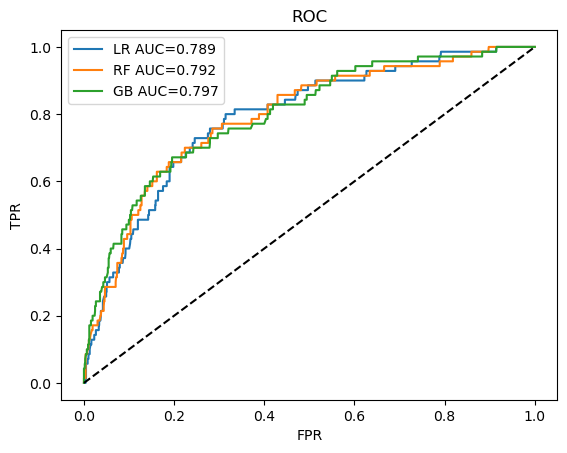

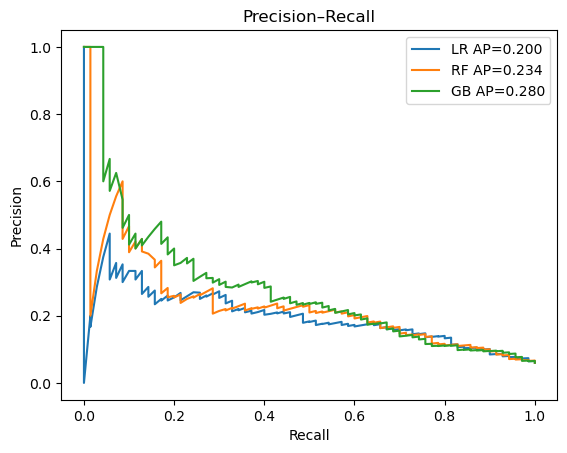

In [4]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, proba_gb)

plt.plot(fpr_lr,tpr_lr,label=f"LR AUC={roc_auc_score(y_test,proba_lr):.3f}")
plt.plot(fpr_rf,tpr_rf,label=f"RF AUC={roc_auc_score(y_test,proba_rf):.3f}")
plt.plot(fpr_gb,tpr_gb,label=f"GB AUC={roc_auc_score(y_test,proba_gb):.3f}")
plt.plot([0,1],[0,1],"k--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

prec_lr, rec_lr, _ = precision_recall_curve(y_test, proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, proba_rf)
prec_gb, rec_gb, _ = precision_recall_curve(y_test, proba_gb)

plt.plot(rec_lr,prec_lr,label=f"LR AP={average_precision_score(y_test,proba_lr):.3f}")
plt.plot(rec_rf,prec_rf,label=f"RF AP={average_precision_score(y_test,proba_rf):.3f}")
plt.plot(rec_gb,prec_gb,label=f"GB AP={average_precision_score(y_test,proba_gb):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend(); plt.show()

## Umbral por negocio (barrido + Top - %)

In [ ]:
# Helpers 
def sweep_thresholds(y_true, y_score, name="model", steps=101):
    """Tabla de métricas para un barrido de umbrales."""
    thrs = np.linspace(0.01, 0.99, steps)
    rows = []
    for t in thrs:
        y_pred = (y_score >= t).astype(int)
        rows.append({
            "modelo":  name,
            "thr":     float(t),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall":    recall_score(y_true, y_pred),
            "f1":        f1_score(y_true, y_pred, zero_division=0),
        })
    return pd.DataFrame(rows)

def top_k_threshold(y_score, top_frac=0.10):
    """Umbral que deja arriba el top 'top_frac' de probabilidades."""
    y_score = np.asarray(y_score).ravel()
    k = max(1, int(len(y_score) * top_frac))
    return float(np.sort(y_score)[-k])

# Reunir predicciones disponibles 
available_preds = {}
if "proba_lr" in globals(): available_preds["LogReg"]       = np.asarray(proba_lr).ravel()
if "proba_rf" in globals(): available_preds["RandomForest"] = np.asarray(proba_rf).ravel()
if "proba_gb" in globals(): available_preds["GradBoost"]    = np.asarray(proba_gb).ravel()

if not available_preds:
    raise RuntimeError("No existen vectores de probabilidad (proba_lr / proba_rf / proba_gb).")

# Elegir el ganador: si existe cmp se usa; si no, por PR-AUC calculada aquí 
if "cmp" in globals() and isinstance(cmp, pd.DataFrame) and "PR_AUC" in cmp.columns and "Modelo" in cmp.columns:
    # Asegura índice por nombre del modelo
    cmp_idx = cmp.set_index("Modelo") if "Modelo" in cmp.columns else cmp
    # Normaliza posibles variaciones del nombre
    def _canon(x):
        x = str(x).lower()
        if "log" in x: return "LogReg"
        if "boost" in x: return "GradBoost"
        if "forest" in x: return "RandomForest"
        return x
    cmp_idx.index = [ _canon(i) for i in cmp_idx.index ]
    # Filtra a los que sí tenemos
    common = [m for m in ["GradBoost","RandomForest","LogReg"] if m in cmp_idx.index and m in available_preds]
    if not common:
        # Fallback a cálculo directo
        ap_scores = {k: average_precision_score(y_test, v) for k,v in available_preds.items()}
        winner_name = max(ap_scores, key=ap_scores.get)
    else:
        winner_name = cmp_idx.loc[common, "PR_AUC"].astype(float).idxmax()
else:
    ap_scores = {k: average_precision_score(y_test, v) for k,v in available_preds.items()}
    winner_name = max(ap_scores, key=ap_scores.get)

proba_win = available_preds[winner_name]
print(f"Modelo ganador por PR-AUC: {winner_name}")

# Barrido de umbrales 
thr_table = sweep_thresholds(y_test, proba_win, name=winner_name)
display(thr_table.sort_values("f1", ascending=False).head(10))

# Umbrales por Top-K% 
thr_top10 = top_k_threshold(proba_win, top_frac=0.10)
thr_top05 = top_k_threshold(proba_win, top_frac=0.05)
print("thr_top10:", round(thr_top10,4), "| thr_top05:", round(thr_top05,4))

# Reporte en cada umbral de negocio 
def report_at(thr):
    y_pred = (proba_win >= thr).astype(int)
    print(f"\n== {winner_name} @ thr={thr:.4f} ==")
    print(" precision:", round(precision_score(y_test, y_pred, zero_division=0), 4),
          "| recall:",   round(recall_score(y_test, y_pred), 4),
          "| f1:",       round(f1_score(y_test, y_pred, zero_division=0), 4))

report_at(thr_top10)
report_at(thr_top05)

# Ranking de clientes y marcaje de Top-K
ranking = pd.DataFrame({
    "proba":  proba_win,
    "y_true": y_test.values
}, index=X_test.index).sort_values("proba", ascending=False)
ranking["Top10pct"] = (ranking["proba"] >= thr_top10).astype(int)
ranking["Top5pct"]  = (ranking["proba"] >= thr_top05).astype(int)

print("\nTop10% seleccionados:", int(ranking["Top10pct"].sum()),
      "| Top5%:", int(ranking["Top5pct"].sum()))

Modelo ganador por PR-AUC: GradBoost


,modelo,thr,precision,recall,f1
16,GradBoost,0.1668,0.300000,0.385714,0.337500
15,GradBoost,0.1570,0.285714,0.400000,0.333333
14,GradBoost,0.1472,0.271028,0.414286,0.327684
13,GradBoost,0.1374,0.253968,0.457143,0.326531
11,GradBoost,0.1178,0.226994,0.528571,0.317597
12,GradBoost,0.1276,0.237410,0.471429,0.315789
17,GradBoost,0.1766,0.289157,0.342857,0.313725
10,GradBoost,0.1080,0.213542,0.585714,0.312977
18,GradBoost,0.1864,0.301370,0.314286,0.307692
19,GradBoost,0.1962,0.304348,0.300000,0.302158


thr_top10: 0.1418 | thr_top05: 0.2137

== GradBoost @ thr=0.1418 ==
 precision: 0.25 | recall: 0.4143 | f1: 0.3118

== GradBoost @ thr=0.2137 ==
 precision: 0.3276 | recall: 0.2714 | f1: 0.2969

Top10% seleccionados: 116 | Top5%: 58


## Entrenamiento final + exportación del modelo

In [ ]:

# 1) Unir train + test para reentrenar el modelo final
df_train_fx = pd.DataFrame(X_train, index=X_train.index, columns=FEATURES)
df_test_fx  = pd.DataFrame(X_test,  index=X_test.index,  columns=FEATURES)

df_all = pd.concat([
    df_train_fx.assign(**{TARGET_COL: y_train.values}),
    df_test_fx.assign(**{TARGET_COL: y_test.values})
], axis=0)

X_all = df_all[FEATURES]
y_all = df_all[TARGET_COL].astype(int)

# 2) Elegir el best_estimator_ según el ganador
if winner_name == "LogReg":
    final_model = gs_lr.best_estimator_
elif winner_name == "RandomForest":
    final_model = gs_rf.best_estimator_
else:  # "GradBoost"
    final_model = gs_gb.best_estimator_

# 3) Reentrenar con todo el dataset
final_model.fit(X_all, y_all)

# 4) Obtener probabilidades 
scores_all = final_model.predict_proba(X_all)[:, 1]

# 5) Construir ranking global y exportar Top-K
out = df_all.copy()
out["Cliente_ID"] = out.index
out["prob_compra"] = scores_all
out = out.sort_values("prob_compra", ascending=False)

# Top 10% y 5%
top10 = out.head(int(0.10 * len(out)))[["Cliente_ID","prob_compra", TARGET_COL]]
top05 = out.head(int(0.05 * len(out)))[["Cliente_ID","prob_compra", TARGET_COL]]

outdir = Path("notebooks/outputs")
outdir.mkdir(parents=True, exist_ok=True)
top10.to_csv(outdir / "clientes_top10pct.csv", index=False)
top05.to_csv(outdir / "clientes_top5pct.csv", index=False)

print("Exportado:")
print("  →", outdir / "clientes_top10pct.csv")
print("  →", outdir / "clientes_top5pct.csv")
print("Tasa observada en Top10%:", round(top10[TARGET_COL].mean(), 4),
      "| Top5%:", round(top05[TARGET_COL].mean(), 4))

# 6) Guardar el modelo final 
model_dir = Path("notebooks/outputs")
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / f"final_model_{winner_name}.joblib"
joblib.dump(final_model, model_path)
print("Modelo guardado en:", model_path)

# 7) Vista rápida del TOP-20
display(out.head(20)[["Cliente_ID","prob_compra", TARGET_COL]])

Exportado:
  → notebooks/outputs/clientes_top10pct.csv
  → notebooks/outputs/clientes_top5pct.csv
Tasa observada en Top10%: 0.2715 | Top5%: 0.3677
Modelo guardado en: notebooks/outputs/final_model_GradBoost.joblib


,Cliente_ID,prob_compra,MoHoPol
355,355,0.754321,1
872,872,0.703185,1
884,884,0.623235,1
1071,1071,0.590367,1
576,576,0.587917,1
1110,1110,0.559355,1
4146,4146,0.546042,1
1060,1060,0.499817,1
1690,1690,0.466850,1
945,945,0.465432,1


## Listado de clientes con su respecitvo porcentaje, ranking y banderas 



In [19]:
def detect_id_column(df: pd.DataFrame):
    """Detecta una columna de ID probable (cliente, case, etc.)"""
    candidates = [
        c for c in df.columns 
        if "id" in c.lower() or c.lower() in ["rowid", "customerid", "clientid", "cliente_id", "case_id"]
    ]
    return candidates[0] if candidates else None

id_col = detect_id_column(df_all)

# Crear copia con features + resultados
scored = df_all[FEATURES].copy()
scored[TARGET_COL] = y_all.values
scored["prob_compra"] = scores_all
scored["prob_pct"] = scored["prob_compra"] * 100.0

# Añadir columna de ID
if id_col and id_col in df_all.columns:
    scored["Cliente_ID"] = df_all[id_col].values
else:
    scored["Cliente_ID"] = df_all.index

# Ordenar y asignar ranking
scored = scored.sort_values("prob_compra", ascending=False).reset_index(drop=True)
scored["rank"] = np.arange(1, len(scored) + 1)
scored["is_top10pct"] = scored["rank"] <= int(0.10 * len(scored))
scored["is_top5pct"] = scored["rank"] <= int(0.05 * len(scored))

# Asignar deciles (1 = mejor, 10 = peor)
try:
    scored["decile"] = pd.qcut(scored["prob_compra"], 10, labels=list(range(10, 0, -1)))
except Exception:
    scored["decile"] = np.nan

# Mostrar vista rápida
cols_view = ["rank", "Cliente_ID", "prob_pct", "prob_compra", TARGET_COL, "is_top10pct", "is_top5pct", "decile"]
display(
    scored[cols_view]
    .head(20)
    .style.format({"prob_pct": "{:.2f}%", "prob_compra": "{:.4f}"})
    .hide(axis="index")
)

# Exportar listado completo
full_path = outdir / "clientes_scored_full.csv"
scored[["rank", "Cliente_ID", "prob_pct", "prob_compra", TARGET_COL, "is_top10pct", "is_top5pct", "decile"]] \
    .to_csv(full_path, index=False)

print("Listado completo guardado en:", full_path)

rank,Cliente_ID,prob_pct,prob_compra,MoHoPol,is_top10pct,is_top5pct,decile
1,4,75.43%,0.7543,1,True,True,1
2,6,70.32%,0.7032,1,True,True,1
3,2,62.32%,0.6232,1,True,True,1
4,2,59.04%,0.5904,1,True,True,1
5,5,58.79%,0.5879,1,True,True,1
6,3,55.94%,0.5594,1,True,True,1
7,4,54.60%,0.5460,1,True,True,1
8,9,49.98%,0.4998,1,True,True,1
9,6,46.68%,0.4668,1,True,True,1
10,4,46.54%,0.4654,1,True,True,1


Listado completo guardado en: notebooks/outputs/clientes_scored_full.csv


## Modelo ganador

In [ ]:
feat_names = np.array(FEATURES)

def _get_inner_estimator(est):
    """Devuelve el estimador final si viene dentro de un Pipeline."""
    try:
        return est.named_steps["clf"]
    except Exception:
        return est

def _top(df, col, k=15):
    """Ordena y muestra las k variables más importantes."""
    df = df.sort_values(col, ascending=False).head(k).reset_index(drop=True)
    display(df)
    return df

inner_est = _get_inner_estimator(final_model)
print(f"Modelo ganador: {winner_name}")

#  1) Importancia nativa 
if winner_name == "LogReg" and hasattr(inner_est, "coef_"):
    coefs = pd.DataFrame({
        "feature": feat_names,
        "coef": inner_est.coef_[0]
    })
    coefs["abs_coef"] = coefs["coef"].abs()
    print("\nTop-15 | Importancia (|coef|) — LogReg")
    imp_native = _top(coefs[["feature","coef","abs_coef"]], "abs_coef", k=15)

elif hasattr(inner_est, "feature_importances_"):
    importances = pd.DataFrame({
        "feature": feat_names,
        "importance": inner_est.feature_importances_
    })
    print(f"\nTop-15 | Importancia nativa — {winner_name}")
    imp_native = _top(importances, "importance", k=15)

else:
    print("Advertencia: el estimador no expone coef_ ni feature_importances_.")
    imp_native = pd.DataFrame()

# 2) Permutation Importance (PR-AUC) 
# Alinear muestreo para evitar errores de índices duplicados
rng = np.random.RandomState(RANDOM_STATE)
sample_n = min(1500, len(X_all))
idx_pos = rng.choice(len(X_all), size=sample_n, replace=False)

X_s = X_all.iloc[idx_pos].copy()

# Garantizar que y_all sea Series del mismo largo
if not isinstance(y_all, pd.Series):
    y_all = pd.Series(y_all, index=np.arange(len(y_all)), name=TARGET_COL)
y_s = y_all.iloc[idx_pos].copy()

print("Shapes para permutation_importance ->", X_s.shape, y_s.shape)

# Scorer explícito (usa PR-AUC)
ap_scorer = make_scorer(average_precision_score, needs_proba=True)

# Cálculo de Permutation Importance
perm = permutation_importance(
    final_model,
    X_s, y_s,
    n_repeats=5,
    random_state=RANDOM_STATE,
    scoring=ap_scorer,
    n_jobs=-1
)

# Resultados a DataFrame
perm_df = pd.DataFrame({
    "feature": feat_names,
    "perm_importance": perm.importances_mean,
    "perm_std": perm.importances_std
})

print("\nTop-15 | Permutation Importance (PR-AUC drop)")
imp_perm = _top(perm_df[["feature","perm_importance","perm_std"]], "perm_importance", k=15)

Modelo ganador: GradBoost

Top-15 | Importancia nativa — GradBoost


,feature,importance
0,CAR_CROSS,0.166443
1,ContrCarPol,0.152626
2,FIRE_CROSS,0.130713
3,DemLoLeEdu,0.114556
4,CMainType,0.111446
5,DemAvgIncome,0.076383
6,ContrFirePol,0.066697
7,DemLowestInc,0.058916
8,DemHiLeEdu,0.057321
9,DemMidInc,0.025520


Shapes para permutation_importance -> (1500, 12) (1500,)

Top-15 | Permutation Importance (PR-AUC drop)


,feature,perm_importance,perm_std
0,DemLoLeEdu,0.094920,0.025369
1,DemAvgIncome,0.094845,0.014541
2,CAR_CROSS,0.080564,0.008213
3,CMainType,0.065644,0.028048
4,ContrCarPol,0.054785,0.014558
5,DemHiLeEdu,0.053272,0.013267
6,ContrPrivIns,0.031228,0.007498
7,DemMidInc,0.029142,0.004818
8,DemLowestInc,0.021622,0.013328
9,FIRE_CROSS,0.020269,0.017870


## Métricas de negocio en umbrales (Top-10% / Top-5%)

In [ ]:
def business_report(y_true, y_score, thr, label="Top-X%"):
    """
    Calcula métricas de negocio para un umbral dado.
    Incluye precisión, recall, F1, tasa de contacto y tasa de captura.
    """
    # Predicciones según el umbral
    y_pred = (y_score >= thr).astype(int)

    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    contactados = int((y_pred == 1).sum())
    total = len(y_true)

    # Hitrate = precisión
    hitrate = tp / max(1, contactados)

    # Capture = recall 
    capture = tp / max(1, (y_true == 1).sum())

    return pd.Series({
        "label": label,
        "threshold": float(thr),
        "contactados": contactados,
        "%contactados": round(100 * contactados / total, 2),
        "TP": int(tp),
        "FP": int(fp),
        "FN": int(fn),
        "TN": int(tn),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4),
        "hit_rate(=precision)": round(hitrate, 4),
        "capture(=recall)": round(capture, 4),
    })

# Aplicación a los umbrales definidos 
rep10 = business_report(y_test, proba_win, thr_top10, "Top-10%")
rep05 = business_report(y_test, proba_win, thr_top05, "Top-5%")

# Tabla resumen de métricas de negocio
biz_tbl = pd.concat([rep10, rep05], axis=1).T

print(" Métricas de negocio en Top-10% y Top-5%:")
display(biz_tbl)

 Métricas de negocio en Top-10% y Top-5%:


,label,threshold,contactados,%contactados,TP,FP,FN,TN,precision,recall,f1,hit_rate(=precision),capture(=recall)
0,Top-10%,0.141823,116,9.96,29,87,41,1008,0.25,0.4143,0.3118,0.25,0.4143
1,Top-5%,0.213697,58,4.98,19,39,51,1056,0.3276,0.2714,0.2969,0.3276,0.2714


## Lift / Gains 

In [ ]:

def lift_table(y_true, y_score, n_bins=10):
    """
    Construye una tabla por deciles ordenados por score de mayor a menor,
    con acumulados de tamaño, positivos, gain% y lift.
    """
    df = pd.DataFrame({"y": np.asarray(y_true).ravel(),
                       "score": np.asarray(y_score).ravel()})
    # Orden descendente por probabilidad
    df = df.sort_values("score", ascending=False).reset_index(drop=True)

    # Asignación de deciles (1 = mejor score)
    df["bin"] = pd.qcut(df.index, q=n_bins, labels=range(1, n_bins+1))

    # Agregación por decil
    grp = (df.groupby("bin")
             .agg(n=("y","size"),
                  positives=("y","sum"),
                  avg_score=("score","mean"))
             .reset_index())

    # Acumulados
    grp["cum_n"]   = grp["n"].cumsum()
    grp["cum_pos"] = grp["positives"].cumsum()

    base_rate = df["y"].mean()             # tasa base del conjunto
    total_pos = df["y"].sum()
    total_n   = len(df)

    # Gains: % de positivos acumulados capturados vs total
    grp["gain_%"] = 100 * grp["cum_pos"] / max(1, total_pos)

    # Lift: tasa de positivos del decil / tasa base
    grp["lift"] = (grp["positives"] / grp["n"]) / max(1e-9, base_rate)

    # Porcentaje de población acumulado 
    grp["cum_pop_%"] = 100 * grp["cum_n"] / total_n

    return grp, float(base_rate)


#  Cálculo de la tabla con el modelo ganador (proba_win)
lt, base_rate = lift_table(y_test, proba_win, n_bins=10)

print(f"Tasa base (positivos en test): {base_rate:.4f}")
display(lt)

Tasa base (positivos en test): 0.0601


,bin,n,positives,avg_score,cum_n,cum_pos,gain_%,lift,cum_pop_%
0,1,117,29,0.219454,117,29,41.428571,4.125153,10.042918
1,2,116,15,0.114544,233,44,62.857143,2.152094,20.000000
2,3,117,5,0.076841,350,49,70.000000,0.711233,30.042918
3,4,116,5,0.052228,466,54,77.142857,0.717365,40.000000
4,5,117,4,0.040263,583,58,82.857143,0.568987,50.042918
5,6,116,7,0.031315,699,65,92.857143,1.004310,60.000000
6,7,116,2,0.024563,815,67,95.714286,0.286946,69.957082
7,8,117,1,0.018961,932,68,97.142857,0.142247,80.000000
8,9,116,1,0.014261,1048,69,98.571429,0.143473,89.957082
9,10,117,1,0.009098,1165,70,100.000000,0.142247,100.000000
